In [11]:
# best data (98 patients)
import pandas as pd

radiomics_df = pd.read_excel("survival_radiomics.xlsx", engine='openpyxl')
target_df = pd.read_excel("db_basis_survival.xlsx", engine='openpyxl')

merged_df = pd.merge(radiomics_df, target_df, on='PP')
merged_df = merged_df.set_index('PP')

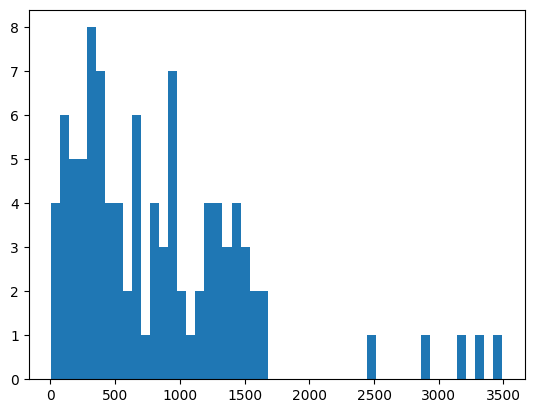

In [12]:
import matplotlib.pyplot as plt

T = merged_df["Duration"]
E = merged_df["Event"]
plt.hist(T, bins = 50)
plt.show()

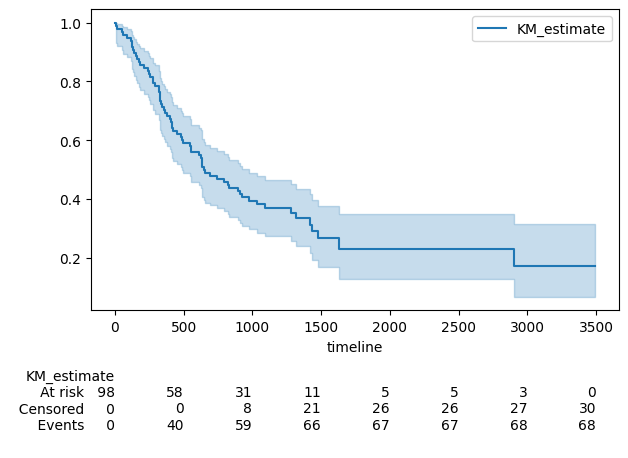

In [13]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function(at_risk_counts=True);

In [14]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)
#means that 50% chance of surviving for more than 634 days

651.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   490.0                   973.0


# COX REGRESSION (sklearn adapter)

### Training and then testing on all data (data leakage). This is a test to make sure everything is working correctly

## Modeling with Train and Test splits

#### repeated cross validation

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

X = merged_df.drop('Duration', axis=1)  # keep as a dataframe
y = merged_df['Duration']

# Define the number of folds and repeats, and an empty list to store the scores
num_folds = 5
num_repeats = 10
scores = []

for r in range(num_repeats):
    print(f"--- Repeat: {r + 1} ---")
    
    # Generate indices for splits
    np.random.seed(r+420)  # change the seed for each repeat
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_sizes = (len(X) // num_folds) * np.ones(num_folds, dtype=int)  # equally divide indices
    fold_sizes[:len(X) % num_folds] += 1  # if len(X) is not exactly divisible by num_folds, assign remainder to first few

    current = 0
    splits = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        splits.append((indices[start:stop], np.concatenate((indices[:start], indices[stop:]))))  # (test, train)
        current = stop

    # Perform cross-validation
    for i, (test_idx, train_idx) in enumerate(splits):
        print(f"Fold: {i + 1}")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Drop 'Event' column
        X_train_new = X_train.drop('Event', axis=1)
        X_test_new = X_test.drop('Event', axis=1)
        
        #variance threshold
        selector = VarianceThreshold(threshold=0.1)  # Adjust as needed
        X_train_new = selector.fit_transform(X_train_new)
        X_test_new = selector.transform(X_test_new)
        
        # Scale the data
        scaler = StandardScaler()
        scaler = MinMaxScaler()
        X_train_new = scaler.fit_transform(X_train_new)
        X_test_new = scaler.transform(X_test_new)
        
        # Perform PCA
        pca = PCA(n_components=20)
        X_train_new = pca.fit_transform(X_train_new)
        X_test_new = pca.transform(X_test_new)
        
        # Convert back to DataFrame
        X_train_new = pd.DataFrame(X_train_new)
        X_test_new = pd.DataFrame(X_test_new)
        
        # Add back indices
        X_train_new.index = X_train.index
        X_test_new.index = X_test.index
        
        # Add 'Event' column back
        X_train_new['Event'] = X_train['Event']
        X_test_new['Event'] = X_test['Event']
        
        # Instantiate CoxRegression object
        CoxRegression = sklearn_adapter(CoxPHFitter, event_col='Event')
        sk_cph = CoxRegression(penalizer=1e-5)
        sk_cph.fit(X_train_new, y_train)
        
        # Calculate and store the score
        score = sk_cph.score(X_test_new, y_test)
        scores.append(score)

        print(f"Score: {score}")
        print("-----------------------------")

# Calculate mean
mean_score = np.mean(scores)

print(f"Mean Score: {mean_score}")

--- Repeat: 1 ---
Fold: 1
Score: 0.6511627906976745
-----------------------------
Fold: 2
Score: 0.375
-----------------------------
Fold: 3
Score: 0.5857988165680473
-----------------------------
Fold: 4
Score: 0.5755395683453237
-----------------------------
Fold: 5
Score: 0.6242038216560509
-----------------------------
--- Repeat: 2 ---
Fold: 1
Score: 0.6
-----------------------------
Fold: 2
Score: 0.398876404494382
-----------------------------
Fold: 3
Score: 0.656441717791411
-----------------------------
Fold: 4
Score: 0.7417218543046358
-----------------------------
Fold: 5
Score: 0.6258503401360545
-----------------------------
--- Repeat: 3 ---
Fold: 1
Score: 0.7378048780487805
-----------------------------
Fold: 2
Score: 0.5714285714285714
-----------------------------
Fold: 3
Score: 0.4883720930232558
-----------------------------
Fold: 4
Score: 0.6217948717948718
-----------------------------
Fold: 5
Score: 0.631578947368421
-----------------------------
--- Repeat: 4 ---

# Random Forest Survival

#### 10 different cv with 5 folds

In [16]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sksurv.ensemble import RandomSurvivalForest
from sklearn.decomposition import PCA

X = merged_df.drop(['Duration', 'Event'], axis=1)  # keep as a dataframe
y = merged_df[['Event','Duration']]

#change y to array of tuples (Event, Duration)
y = np.array([(bool(arr[0]), arr[1]) for arr in y.values], dtype=[('boolean', bool), ('integer', int)])

# Define the number of folds, repeats and an empty list to store the scores
num_folds = 5
num_repeats = 10
scores = []

# Create the RepeatedKFold object
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=1)

# Perform Repeated K-Fold cross-validation
for i, (train_index, test_index) in enumerate(rkf.split(X)):
    print(f"Fold: {(i % num_folds) + 1}, Repeat: {i // num_folds + 1}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #variance threshold
    selector = VarianceThreshold(threshold=0.1)  # Adjust as needed
    X_train_new = selector.fit_transform(X_train)
    X_test_new = selector.transform(X_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_new = scaler.fit_transform(X_train_new)
    X_test_new = scaler.transform(X_test_new)
    
    # Perform PCA
    pca = PCA(n_components=20)
    X_train_new = pca.fit_transform(X_train_new)
    X_test_new = pca.transform(X_test_new)
    
    # Convert back to DataFrame
    X_train_new = pd.DataFrame(X_train_new)
    X_test_new = pd.DataFrame(X_test_new)
    
    # Add back indices
    X_train_new.index = X_train.index
    X_test_new.index = X_test.index
    
    # Instantiate RandomSurvivalForest object
    rsf = RandomSurvivalForest()
    rsf.fit(X_train_new, y_train)
    
    # Calculate and store the score
    score = rsf.score(X_test_new, y_test)
    scores.append(score)
    
    print(f"Score: {score}")
    print("-----------------------------")

# Calculate mean and 95% confidence interval of the scores
mean_score = np.mean(scores)

print(f"Mean Score: {mean_score}")

Fold: 1, Repeat: 1
Score: 0.6068965517241379
-----------------------------
Fold: 2, Repeat: 1
Score: 0.4533333333333333
-----------------------------
Fold: 3, Repeat: 1
Score: 0.3924731182795699
-----------------------------
Fold: 4, Repeat: 1
Score: 0.5253164556962026
-----------------------------
Fold: 5, Repeat: 1
Score: 0.47096774193548385
-----------------------------
Fold: 1, Repeat: 2
Score: 0.47953216374269003
-----------------------------
Fold: 2, Repeat: 2
Score: 0.48633879781420764
-----------------------------
Fold: 3, Repeat: 2
Score: 0.45251396648044695
-----------------------------
Fold: 4, Repeat: 2
Score: 0.5337837837837838
-----------------------------
Fold: 5, Repeat: 2
Score: 0.49137931034482757
-----------------------------
Fold: 1, Repeat: 3
Score: 0.6285714285714286
-----------------------------
Fold: 2, Repeat: 3
Score: 0.38333333333333336
-----------------------------
Fold: 3, Repeat: 3
Score: 0.4873417721518987
-----------------------------
Fold: 4, Repeat: 3


# GDB survival (ComponentwiseGradientBoostingSurvivalAnalysis)

#### 10 different cv with 5 folds

In [17]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sklearn.decomposition import PCA

X = merged_df.drop(['Duration', 'Event'], axis=1)  # keep as a dataframe
y = merged_df[['Event','Duration']]

#change y to array of tuples (Event, Duration)
y = np.array([(bool(arr[0]), arr[1]) for arr in y.values], dtype=[('boolean', bool), ('integer', int)])

# Define the number of folds, repeats and an empty list to store the scores
num_folds = 5
num_repeats = 10
scores = []

# Create the RepeatedKFold object
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=1)

# Perform Repeated K-Fold cross-validation
for i, (train_index, test_index) in enumerate(rkf.split(X)):
    print(f"Fold: {(i % num_folds) + 1}, Repeat: {i // num_folds + 1}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #variance threshold
    selector = VarianceThreshold(threshold=0.1)  # Adjust as needed
    X_train_new = selector.fit_transform(X_train)
    X_test_new = selector.transform(X_test)
    
    # Scale the data
    scaler = StandardScaler()
    scaler = MinMaxScaler()

    X_train_new = scaler.fit_transform(X_train_new)
    X_test_new = scaler.transform(X_test_new)
    
    # Perform PCA
    pca = PCA(n_components=22)
    X_train_new = pca.fit_transform(X_train_new)
    X_test_new = pca.transform(X_test_new)
    
    # Convert back to DataFrame
    X_train_new = pd.DataFrame(X_train_new)
    X_test_new = pd.DataFrame(X_test_new)
    
    # Add back indices
    X_train_new.index = X_train.index
    X_test_new.index = X_test.index
    
    # Instantiate GB object
    gdb = ComponentwiseGradientBoostingSurvivalAnalysis(loss="coxph")
    gdb.fit(X_train_new, y_train)
    
    # Calculate and store the score
    score = gdb.score(X_test_new, y_test)
    scores.append(score)
    
    print(f"Score: {score}")
    print("-----------------------------")

# Calculate mean and 95% confidence interval of the scores
mean_score = np.mean(scores)

print(f"Mean Score: {mean_score}")

Fold: 1, Repeat: 1
Score: 0.5241379310344828
-----------------------------
Fold: 2, Repeat: 1
Score: 0.4
-----------------------------
Fold: 3, Repeat: 1
Score: 0.43548387096774194
-----------------------------
Fold: 4, Repeat: 1
Score: 0.5316455696202531
-----------------------------
Fold: 5, Repeat: 1
Score: 0.7290322580645161
-----------------------------
Fold: 1, Repeat: 2
Score: 0.5672514619883041
-----------------------------
Fold: 2, Repeat: 2
Score: 0.4426229508196721
-----------------------------
Fold: 3, Repeat: 2
Score: 0.6033519553072626
-----------------------------
Fold: 4, Repeat: 2
Score: 0.581081081081081
-----------------------------
Fold: 5, Repeat: 2
Score: 0.6206896551724138
-----------------------------
Fold: 1, Repeat: 3
Score: 0.5371428571428571
-----------------------------
Fold: 2, Repeat: 3
Score: 0.4666666666666667
-----------------------------
Fold: 3, Repeat: 3
Score: 0.45569620253164556
-----------------------------
Fold: 4, Repeat: 3
Score: 0.66911764705